# 1. Loading the dataset and Importing Libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
import pmdarima
import statsmodels.api as sm

from pmdarima import auto_arima
from itertools import repeat
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from fbprophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from numpy import array
from pandas import concat

In [2]:
train = pd.read_csv('train_2.csv') # select a subset
key = pd.read_csv('key_2.csv')
# Changing Missing data to zero
#train.fillna(0, inplace=True)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


## 1.1 Splitting Pages, Site and Access Agent

In [3]:
df = train.copy()

data = [page.split('_') for page in df.Page]
access = ['_'.join(page[-2:]) for page in data]
site = [page[-3] for page in data]
page = ['_'.join(page[:-3]) for page in data]


df['PageTitle'] = page
df['Site'] = site
df['AccessAgent'] = access

# shift column 'Name' to first position 'PageTitle','Site',
first_column = df.pop('AccessAgent')
df.insert(1,'AccessAgent', first_column)

first_column = df.pop('PageTitle')
df.insert(1,'PageTitle', first_column)

first_column = df.pop('Site')
df.insert(1,'Site', first_column)

df.head()

,Page,Site,PageTitle,AccessAgent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,2NE1,all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,2PM,all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,3C,all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,4minute,all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,zh.wikipedia.org,52_Hz_I_Love_You,all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


## 1.2 Spliting Access and Agent from AccessAgent

In [4]:
AccessAgent = [AccessAgent.split('_') for AccessAgent in df.AccessAgent]

access = [Acc[0] for Acc in AccessAgent]
agent = [Acc[1] for Acc in AccessAgent]

df['Access'] = access
df['Agent'] = agent

split = [page.split('.') for page in df.Site]
lang  = [language[0] for language in split]

df['lang'] = lang


# shift column 'Name' to first position 'PageTitle','Site',
first_column = df.pop('Access')
df.insert(4,'Access', first_column)

first_column = df.pop('Agent')
df.insert(4,'Agent', first_column)

first_column = df.pop('lang')
df.insert(4,'lang', first_column)

df.fillna(0, inplace=True)
df.head()

,Page,Site,PageTitle,AccessAgent,lang,Agent,Access,2015-07-01,2015-07-02,2015-07-03,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,2NE1,all-access_spider,zh,spider,all-access,18.0,11.0,5.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,2PM,all-access_spider,zh,spider,all-access,11.0,14.0,15.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,3C,all-access_spider,zh,spider,all-access,1.0,0.0,1.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,4minute,all-access_spider,zh,spider,all-access,35.0,13.0,10.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,zh.wikipedia.org,52_Hz_I_Love_You,all-access_spider,zh,spider,all-access,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


# 3. Feature Engineering

We will be focusing on last 15 days of data from our train dataset. The features that we will be creating are:

In [5]:
last_14_days = train.copy()
last_14_days.drop(last_14_days.columns[[range(1,789)]], axis = 1, inplace = True)
last_14_days

C:\Users\DELL\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:4307: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,Page,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,7.0,7.0,7.0,8.0,2.0,0.0,4.0,3.0,6.0,5.0,2.0,4.0,4.0,8.0,2.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,9.0,2.0,11.0,3.0,3.0,4.0,4.0,7.0,5.0,0.0,5.0,5.0,2.0,2.0,4.0
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,13.0,10.0,21.0,11.0,9.0,11.0,25.0,22.0,47.0,42.0,13.0,9.0,21.0,16.0,6.0
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,10.0,5.0,3.0,9.0,2.0,4.0,6.0,5.0,1.0,5.0,8.0,2.0,4.0,3.0,3.0


In [6]:
target_value = last_14_days.iloc[:,-1:]
last_14_days.drop(last_14_days.columns[[-1]], axis = 1, inplace = True)
last_14_days

,Page,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09
0,2NE1_zh.wikipedia.org_all-access_spider,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0
1,2PM_zh.wikipedia.org_all-access_spider,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0
2,3C_zh.wikipedia.org_all-access_spider,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0
3,4minute_zh.wikipedia.org_all-access_spider,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,7.0,7.0,7.0,8.0,2.0,0.0,4.0,3.0,6.0,5.0,2.0,4.0,4.0,8.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,9.0,2.0,11.0,3.0,3.0,4.0,4.0,7.0,5.0,0.0,5.0,5.0,2.0,2.0
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,13.0,10.0,21.0,11.0,9.0,11.0,25.0,22.0,47.0,42.0,13.0,9.0,21.0,16.0
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,10.0,5.0,3.0,9.0,2.0,4.0,6.0,5.0,1.0,5.0,8.0,2.0,4.0,3.0


In [7]:
last_14_days.fillna(0, inplace=True)
last_14_days.head()

,Page,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09
0,2NE1_zh.wikipedia.org_all-access_spider,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0
1,2PM_zh.wikipedia.org_all-access_spider,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0
2,3C_zh.wikipedia.org_all-access_spider,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0
3,4minute_zh.wikipedia.org_all-access_spider,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0


In [8]:
import datetime
from tqdm import tqdm
from tqdm import tnrange as tnrange

prev_week_val = [[] for i in range(train.shape[0])]

lag_7_value=[] 

    
for j in tqdm(range(train.shape[0])):
    past_7_days_mean=[]
    k=last_14_days.iloc[j].values
    
    for i in range(8,15):
        past_7_days_mean.append(round(k[i-7:i].mean()))
      
    prev_week_val[j]=past_7_days_mean
    lag_7_value.append(k[i-7])

100%|████████████████████████████████████████████████████████████████████████| 145063/145063 [00:53<00:00, 2730.06it/s]


In [9]:
pd.DataFrame(prev_week_val).shape

(145063, 7)

## 3.1 Getting language feature for each language

In [10]:
Page_Names = pd.DataFrame(df[['Page', 'lang','Agent','Access']])
result = pd.concat([last_14_days,Page_Names], axis=1, join='inner')
result = result.T.drop_duplicates().T
result.head()

,Page,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,lang,Agent,Access
0,2NE1_zh.wikipedia.org_all-access_spider,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,zh,spider,all-access
1,2PM_zh.wikipedia.org_all-access_spider,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,zh,spider,all-access
2,3C_zh.wikipedia.org_all-access_spider,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,zh,spider,all-access
3,4minute_zh.wikipedia.org_all-access_spider,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,zh,spider,all-access
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,zh,spider,all-access


In [11]:
lang_feat = []
access_feat = []
agent_feat = []

#for i in range(1,8):

lang_feat.extend(result['lang'])
access_feat.extend(result['Access'])
agent_feat.extend(result['Agent'])

## 3.2 Getting Monthly and Quarterly Features

In [12]:
import datetime
from tqdm import tqdm

lag_30_value= [] 
lag_90_value = []
lag_120_value = []
lag_180_value = []
lag_240_value = []
lag_365_value = []

for j in tqdm(range(df.shape[0])):
    past_30_days=[]
    past_90_days=[]
    past_120_days=[]
    past_180_days=[]
    past_240_days=[]
    past_365_days=[]
    
    k=df.iloc[j].values
    
    #for i in range(,811):
    i = 810
    past_30_days.append(round(k[i-32:i-28].mean()))
    past_90_days.append(round(k[i-92:i-88].mean()))
    past_120_days.append(round(k[i-122:i-118].mean()))
    past_180_days.append(round(k[i-182:i-178].mean()))
    past_240_days.append(round(k[i-242:i-238].mean()))
    past_365_days.append(round(k[i-367:i-263].mean()))
      
    lag_30_value.extend(past_30_days)
    lag_90_value.extend(past_90_days)
    lag_120_value.extend(past_120_days)
    lag_180_value.extend(past_180_days)
    lag_240_value.extend(past_240_days)
    lag_365_value.extend(past_365_days)

100%|█████████████████████████████████████████████████████████████████████████| 145063/145063 [02:33<00:00, 945.50it/s]


## 3.3 Getting Fourier Transformed Features

In [15]:
from scipy import fft

# We will be applying Fourier Transformation to our dataset, We will then be using top 3 peaks from our graph and those will be our remaining features
# for our problem. 3 X-coordinates and 3 Y-coordinates will give us total 6 features.
fourier_feat1_x=[]
fourier_feat2_x=[]
fourier_feat3_x=[]
fourier_feat1_y=[]
fourier_feat2_y=[]
fourier_feat3_y=[]

for t in tnrange(len(df['Page'])):
    data=df.iloc[t].values[7:] # This is the data that we are going to transform into the frequency domain
    data=data-np.mean(data) # At frequency bin 0, we get the mean value of our signal. In order to remove that we are subtracting mean of the data from every datapoint
    x=fft.fft(data) #Fourier Transformation
    freq=np.linspace(0,803//2,803//2) # According to shannon, we can only analyse the frequency of half of the sample, this function creates evenly spaced numbers which will be used as frequency in plot
    y=2/803*np.abs(x[0:803//2]) # Taking absolute values of half data points 

  # Below is the code to create features from the frequency domain
    temp=y.copy()
    temp1=temp[7:]
    temp1=np.sort(temp1)
    k=temp1[len(temp1)-3:]
    fourier_temp1_x=[]
    fourier_temp2_x=[]
    fourier_temp3_x=[]
    fourier_temp1_y=[]
    fourier_temp2_y=[]
    fourier_temp3_y=[]
    
    for i in range(len(k)):
        temp_fourier_x=[]
        temp_fourier_y=[]
        temp_fourier_x.append(freq[list(y).index(k[i])])
        temp_fourier_y.append(list(y).index(k[i]))
        if(i==0):
            #for j in range(7):
            fourier_temp1_x.extend(temp_fourier_x)
            fourier_temp1_y.extend(temp_fourier_y)
        if(i==1):
            #for j in range(7):
            fourier_temp2_x.extend(temp_fourier_x)
            fourier_temp2_y.extend(temp_fourier_y)
        if(i==2):
            #for j in range(7):
            fourier_temp3_x.extend(temp_fourier_x)
            fourier_temp3_y.extend(temp_fourier_y)
    fourier_feat1_x.extend(fourier_temp1_x) 
    fourier_feat2_x.extend(fourier_temp2_x) 
    fourier_feat3_x.extend(fourier_temp3_x)    
    fourier_feat1_y.extend(fourier_temp1_y) 
    fourier_feat2_y.extend(fourier_temp2_y) 
    fourier_feat3_y.extend(fourier_temp3_y)

<ipython-input-15-7bcdce3a1378>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for t in tnrange(len(df['Page'])):


  0%|          | 0/145063 [00:00<?, ?it/s]

## 3.4 Making Data Model Ready

In [16]:
from sklearn.preprocessing import OneHotEncoder,normalize

enc_access_feat = OneHotEncoder(sparse=False)
access_feat_ohe=enc_access_feat.fit_transform(np.array(access_feat).reshape(-1,1))

#enc_week_day = OneHotEncoder(sparse=False)
#week_day_ohe=enc_week_day.fit_transform(np.array(week_day).reshape(-1,1))

enc_lang_feat = OneHotEncoder(sparse=False)
week_lang_ohe=enc_lang_feat.fit_transform(np.array(lang_feat).reshape(-1,1))

enc_agent_feat = OneHotEncoder(sparse=False)
access_feat_ohe=enc_access_feat.fit_transform(np.array(agent_feat).reshape(-1,1))


In [17]:
# We will start with linear regression, so now we have to normalise the numerical features
prev_week_val_feat=normalize(prev_week_val)

lag_7_value_feat=normalize(np.array(lag_7_value).reshape(-1,1),axis=0)
lag_30_value_feat=normalize(np.array(lag_30_value).reshape(-1,1),axis=0)
lag_90_value_feat=normalize(np.array(lag_90_value).reshape(-1,1),axis=0)
lag_120_value_feat=normalize(np.array(lag_120_value).reshape(-1,1),axis=0)
lag_180_value_feat=normalize(np.array(lag_180_value).reshape(-1,1),axis=0)
lag_240_value_feat=normalize(np.array(lag_240_value).reshape(-1,1),axis=0)
lag_365_value_feat=normalize(np.array(lag_365_value).reshape(-1,1),axis=0)


fourier_feat1_x=normalize(np.array(fourier_feat1_x).reshape(-1,1),axis=0)
fourier_feat2_x=normalize(np.array(fourier_feat2_x).reshape(-1,1),axis=0)
fourier_feat3_x=normalize(np.array(fourier_feat3_x).reshape(-1,1),axis=0)
fourier_feat1_y=normalize(np.array(fourier_feat1_y).reshape(-1,1),axis=0)
fourier_feat2_y=normalize(np.array(fourier_feat2_y).reshape(-1,1),axis=0)
fourier_feat3_y=normalize(np.array(fourier_feat3_y).reshape(-1,1),axis=0)

In [18]:
print(access_feat_ohe.shape)
print(week_lang_ohe.shape)
print(access_feat_ohe.shape)
print(prev_week_val_feat.shape)

print(lag_7_value_feat.shape)
print(lag_30_value_feat.shape)
print(lag_90_value_feat.shape)
print(lag_120_value_feat.shape)
print(lag_180_value_feat.shape)
print(lag_240_value_feat.shape)
print(lag_365_value_feat.shape)

print(fourier_feat1_x.shape)
print(fourier_feat2_x.shape)
print(fourier_feat3_x.shape)
print(fourier_feat1_y.shape)
print(fourier_feat2_y.shape)
print(fourier_feat3_y.shape)

(145063, 2)
(145063, 9)
(145063, 2)
(145063, 7)
(145063, 1)
(145063, 1)
(145063, 1)
(145063, 1)
(145063, 1)
(145063, 1)
(145063, 1)
(145063, 1)
(145063, 1)
(145063, 1)
(145063, 1)
(145063, 1)
(145063, 1)


In [19]:
target_value=np.array(target_value).reshape(-1,1)

In [20]:
target_value.shape

(145063, 1)

In [21]:
data=np.column_stack((  access_feat_ohe,
                        week_lang_ohe,
                        access_feat_ohe,
                        prev_week_val_feat,

                        lag_7_value_feat,
                        lag_30_value_feat,
                        lag_90_value_feat,
                        lag_120_value_feat,
                        lag_180_value_feat,
                        lag_240_value_feat,
                        lag_365_value_feat,

                        fourier_feat1_x,
                        fourier_feat2_x,
                        fourier_feat3_x,
                        fourier_feat1_y,
                        fourier_feat2_y,
                        fourier_feat3_y
                     ))


In [22]:
indices = np.random.permutation(train.shape[0])
len(indices)

145063

In [23]:
target_value = np.nan_to_num(target_value)

In [24]:
indices = np.random.permutation(train.shape[0])

training_indices, test_indices = indices[:int(0.75*train.shape[0])], indices[int(0.75*train.shape[0]):] # Taking 75% of data for training
x_train,x_test = data[training_indices,:], data[test_indices,:]
y_train,y_test=target_value[training_indices,:],target_value[test_indices,:]

In [25]:
y_train=y_train.reshape(y_train.shape[0])
y_test=y_test.reshape(y_test.shape[0])

# 4. Modelling

In [27]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from operator import sub,truediv,add
from sklearn.ensemble import RandomForestRegressor

In [28]:
# This will be our performance metric, this is custom build SMAPE 
def smape(actual,visits):
    temp_list=[2 for i in range(len(actual))]
    val1=np.abs(list(map(sub,visits,actual)))
    val2=list(map(add,np.abs(actual),np.abs(visits)))
    val4=list(map(truediv,val2,temp_list))
    val3=[]
    for i in range(len(val4)):
        if(val4[i]==0):
            val3.append(0)
        else:    
            val3.append(val1[i]/val4[i])
    return(np.sum(val3)/len(val3)) 

## 4.1 Baseline Model

In [29]:
df['avg'] = df.iloc[:,7:810].mean(axis = 1)

In [30]:
file1=pd.read_csv('key_2.csv')
file2=pd.read_csv('sample_submission_2.csv')
file1=file1.merge(file2,on='Id')
file1.head()

,Page,Id,Visits
0,007_スペクター_ja.wikipedia.org_all-access_all-agen...,0b293039387a,0
1,007_スペクター_ja.wikipedia.org_all-access_all-agen...,7114389dd824,0
2,007_スペクター_ja.wikipedia.org_all-access_all-agen...,057b02ff1f09,0
3,007_スペクター_ja.wikipedia.org_all-access_all-agen...,bd2aca21caa3,0
4,007_スペクター_ja.wikipedia.org_all-access_all-agen...,c0effb42cdd5,0


In [33]:
ids=file1['Page'].values
visits={} 
for i in tnrange(df.shape[0]):
    date = datetime.date(2017,9,11)
    for j in range(64):
        name=df['Page'][i] + '_' + str(date)
        visits[name] = df['avg'][i]
        date += datetime.timedelta(days=1)

<ipython-input-33-f67b581af71c>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(df.shape[0]):


  0%|          | 0/145063 [00:00<?, ?it/s]

In [34]:
for i in tnrange(file1.shape[0]):
    file1.at[i,'Visits']=round(visits[file1.iloc[i].Page])

<ipython-input-34-7aeab281602b>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(file1.shape[0]):


  0%|          | 0/8993906 [00:00<?, ?it/s]

In [35]:
file1.head()

,Page,Id,Visits
0,007_スペクター_ja.wikipedia.org_all-access_all-agen...,0b293039387a,1384
1,007_スペクター_ja.wikipedia.org_all-access_all-agen...,7114389dd824,1384
2,007_スペクター_ja.wikipedia.org_all-access_all-agen...,057b02ff1f09,1384
3,007_スペクター_ja.wikipedia.org_all-access_all-agen...,bd2aca21caa3,1384
4,007_スペクター_ja.wikipedia.org_all-access_all-agen...,c0effb42cdd5,1384


In [36]:
file1[['Id','Visits']].to_csv('baseline_model_1.1.csv',index=False)

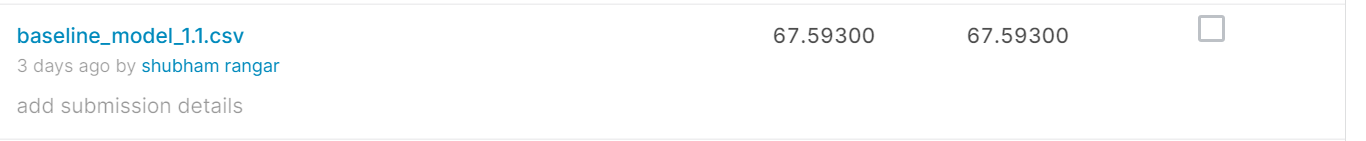

## 4.2 Linear Regression

In [37]:
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4.916334e-06,3.223676e-06,3.952955e-06,8.608024e-06,0.000257,0.001002,0.000956,0.000257,0.001002,0.000956
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.425024e-06,1.579601e-06,6.794141e-07,2.432985e-05,0.004185,0.004450,0.004996,0.004185,0.004450,0.004996
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.781281e-07,1.160523e-06,1.791183e-06,9.744933e-07,0.000440,0.000361,0.000304,0.000440,0.000361,0.000304
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4.446076e-05,3.529925e-05,3.742954e-05,5.622826e-05,0.005506,0.009180,0.000391,0.005506,0.009180,0.000391
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.199180e-05,5.364197e-05,3.718248e-05,8.387139e-05,0.000257,0.000361,0.000434,0.000257,0.000361,0.000434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108792,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.068768e-07,6.447352e-08,9.264738e-08,9.744933e-08,0.000294,0.000561,0.001651,0.000294,0.000561,0.001651
108793,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.425024e-07,1.934206e-07,1.235298e-07,1.299324e-07,0.000257,0.000361,0.000348,0.000257,0.000361,0.000348
108794,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.401166e-05,1.479667e-05,2.322361e-05,2.244583e-05,0.008406,0.004570,0.004996,0.008406,0.004570,0.004996
108795,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.137537e-07,1.289470e-07,1.852948e-07,2.273818e-07,0.004221,0.005733,0.014987,0.004221,0.005733,0.014987


In [38]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train,y_train)
y_pred = reg.predict(x_test)
score = smape(y_test,y_pred)
print("Smape Score for Linear Regression :",score)

Smape Score for Linear Regression : 1.0324370011855561


# Decision Tree

In [119]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

depth = [1, 5, 10, 50,500]
split = [5, 10, 100, 500,1000]

dict_ = {'max_depth': depth, 'min_samples_split': split}
decision_tree_set1 = DecisionTreeRegressor()

reg = GridSearchCV(decision_tree_set1, dict_, cv = 3, scoring=make_scorer(smape,greater_is_better=False), return_train_score = True)
reg.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 5, 10, 50, 500],
                         'min_samples_split': [5, 10, 100, 500, 1000]},
             return_train_score=True,
             scoring=make_scorer(smape, greater_is_better=False))

In [120]:
reg.best_params_ 

{'max_depth': 500, 'min_samples_split': 100}

In [121]:
reg.cv_results_

{'mean_fit_time': array([0.33132593, 0.2738355 , 0.21267255, 0.1955622 , 0.20587492,
        0.93889467, 1.10077469, 0.8927261 , 0.81097102, 0.70427998,
        1.50256673, 2.1118931 , 2.05244962, 1.71548541, 1.47945833,
        4.28544617, 4.23364647, 4.61106912, 3.41539558, 3.15902328,
        5.14978711, 4.74451828, 3.84631419, 3.48202705, 3.26644715]),
 'std_fit_time': array([0.077775  , 0.01068841, 0.0260472 , 0.00530508, 0.00736733,
        0.07083067, 0.1557093 , 0.03779263, 0.01651377, 0.05478087,
        0.05014273, 0.38801117, 0.05822107, 0.0164153 , 0.06440824,
        0.20522172, 0.03041688, 0.69350463, 0.07708432, 0.13445518,
        1.39830202, 0.49575275, 0.05638593, 0.13878955, 0.13839049]),
 'mean_score_time': array([0.12137771, 0.08455451, 0.06970255, 0.0557162 , 0.05755202,
        0.06284444, 0.11272415, 0.06259942, 0.05848885, 0.05466366,
        0.05422537, 0.08010602, 0.07347878, 0.07146422, 0.05798117,
        0.06566676, 0.06267897, 0.07696231, 0.06732702, 0.06

In [122]:
from sklearn.tree import DecisionTreeRegressor

dict_ = {'max_depth': depth, 'min_samples_split': split}
reg = DecisionTreeRegressor(max_depth=500,min_samples_split=100)

reg.fit(x_train,y_train)
y_pred=reg.predict(x_test)
score=smape(y_test,y_pred)
print('smape on DT with best hyperparameter is: ',score)

smape on DT with best hyperparameter is:  0.5164215293410558


# Random Forest

In [126]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

depth = [1, 5, 10, 50,500]
split = [5, 10, 100, 500,1000]

dict_ = {'max_depth': depth, 'min_samples_split': split}
reg = RandomForestRegressor()

reg = GridSearchCV(decision_tree_set1, dict_, cv = 3, scoring=make_scorer(smape,greater_is_better=False), return_train_score = True)
reg.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 5, 10, 50, 500],
                         'min_samples_split': [5, 10, 100, 500, 1000]},
             return_train_score=True,
             scoring=make_scorer(smape, greater_is_better=False))

In [127]:
reg.best_params_ 

{'max_depth': 500, 'min_samples_split': 100}

In [128]:
reg.cv_results_

{'mean_fit_time': array([0.25528749, 0.25821757, 0.25063435, 0.25581137, 0.25084678,
        1.19087783, 1.17428756, 1.17805171, 1.18191163, 1.18088873,
        2.31585693, 2.31646299, 2.27798144, 2.27364771, 2.24707588,
        6.95307755, 6.83962615, 6.22849337, 5.59509881, 5.35413925,
        7.3896695 , 7.17925596, 6.46032373, 5.88693349, 5.53652668]),
 'std_fit_time': array([0.00239425, 0.00644484, 0.00043164, 0.0069702 , 0.00069672,
        0.00112262, 0.00552913, 0.00068057, 0.01801811, 0.00966767,
        0.05009285, 0.03490802, 0.01161002, 0.01954954, 0.00729669,
        0.14295559, 0.07393855, 0.07155726, 0.10415329, 0.09617666,
        0.11679009, 0.06937383, 0.08916412, 0.12472387, 0.08160116]),
 'mean_score_time': array([0.07833322, 0.07905539, 0.08897328, 0.08422105, 0.07901033,
        0.07816307, 0.0782125 , 0.0861117 , 0.07874441, 0.08387629,
        0.08506529, 0.08356754, 0.0835615 , 0.08346009, 0.07850146,
        0.09485936, 0.10939781, 0.0944496 , 0.09426649, 0.08

In [125]:
from sklearn.ensemble import RandomForestRegressor

dict_ = {'max_depth': depth, 'min_samples_split': split}
reg = RandomForestRegressor(max_depth=50,min_samples_split=5)

reg.fit(x_train,y_train)
y_pred=reg.predict(x_test)
score=smape(y_test,y_pred)
print('smape on RF with best hyperparameter is: ',score)

smape on RF with best hyperparameter is:  0.5015755746223289


# Xgboost

In [129]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

random_grid={'learning_rate':[0.01,0.1,1]}
reg=XGBRegressor(max_depth=1000,verbosity=3,n_jobs=-1,n_estimators=250)
rf_random = RandomizedSearchCV(estimator = reg,scoring=make_scorer(smape,greater_is_better=False), param_distributions = random_grid, \
                                cv = 3, verbose=20,n_jobs = -1)
rf_random.fit(x_train, y_train)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits


C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [        nan         nan -0.57706713]
  warnings.warn(


[10:46:16] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:155: Using tree method: 2
[10:46:18] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 28158 extra nodes, 0 pruned nodes, max_depth=46
[10:46:20] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 98256 extra nodes, 0 pruned nodes, max_depth=65
[10:46:22] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 109784 extra nodes, 0 pruned nodes, max_depth=86
[10:46:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 116364 extra nodes, 0 pruned nodes, max_depth=75
[10:46:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 119806 extra nodes, 0 pruned nodes, max_depth=86

[10:47:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:05] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[10:47:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:06] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[10:47:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[10:47:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:47:09] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=1000,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=250, n_jobs=-1,
                                          num_parallel_tree=None,
                                          predictor=

In [130]:
rf_random.best_params_ 

{'learning_rate': 1}

In [131]:
rf_random.cv_results_

{'mean_fit_time': array([1262.60600885, 1251.76159668,  222.41652083]),
 'std_fit_time': array([ 6.4894306 ,  0.07742331, 12.72294446]),
 'mean_score_time': array([0.        , 0.        , 0.70407597]),
 'std_score_time': array([0.        , 0.        , 0.02790901]),
 'param_learning_rate': masked_array(data=[0.01, 0.1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.01},
  {'learning_rate': 0.1},
  {'learning_rate': 1}],
 'split0_test_score': array([        nan,         nan, -0.57841487]),
 'split1_test_score': array([        nan,         nan, -0.57473143]),
 'split2_test_score': array([       nan,        nan, -0.5780551]),
 'mean_test_score': array([        nan,         nan, -0.57706713]),
 'std_test_score': array([       nan,        nan, 0.00165811]),
 'rank_test_score': array([2, 3, 1])}

In [132]:
# Training XgBoost with best hyperparameters
from xgboost import XGBRegressor
reg=XGBRegressor(max_depth=1000,verbosity=3,n_jobs=-1,n_estimators=250,learning_rate=1)
reg.fit(x_train,y_train)
y_pred=reg.predict(x_test)

[10:47:23] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:155: Using tree method: 2
[10:47:24] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 28158 extra nodes, 0 pruned nodes, max_depth=46
[10:47:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 98256 extra nodes, 0 pruned nodes, max_depth=65
[10:47:28] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 109784 extra nodes, 0 pruned nodes, max_depth=86
[10:47:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 116364 extra nodes, 0 pruned nodes, max_depth=75
[10:47:33] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 119806 extra nodes, 0 pruned nodes, max_depth=86

[10:48:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 46 extra nodes, 0 pruned nodes, max_depth=12
[10:48:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:07] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 prun

[10:48:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:08] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[10:48:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[10:48:11] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

[10:48:24] ======== Monitor (0): Learner ========
[10:48:24] Configure: 0.000937s, 1 calls @ 937us

[10:48:24] EvalOneIter: 0.001874s, 250 calls @ 1874us

[10:48:24] GetGradient: 0.029539s, 250 calls @ 29539us

[10:48:24] PredictRaw: 1.89398s, 250 calls @ 1893980us

[10:48:24] UpdateOneIter: 49.2063s, 250 calls @ 49206257us

[10:48:24] ======== Monitor (0): GBTree ========
[10:48:24] BoostNewTrees: 47.2762s, 250 calls @ 47276228us

[10:48:24] CommitModel: 0.000194s, 250 calls @ 194us

[10:48:24] ======== Monitor (0): TreePruner ========
[10:48:24] PrunerUpdate: 0.327377s, 250 calls @ 327377us



In [133]:
score=smape(y_test,y_pred)
print('smape on Xgboost with best hyperparameter is: ',score)

smape on Xgboost with best hyperparameter is:  0.5727506952527796


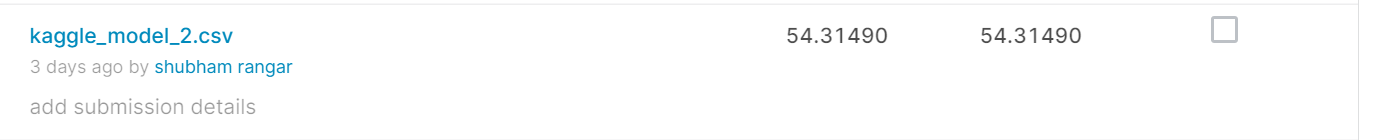

# LSTM

In [3]:
from tqdm import tqdm
from tqdm import tnrange as tnrange

import re
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Activation,LSTM,RepeatVector,TimeDistributed,Flatten,Conv1D,Conv2D,Embedding,Concatenate

In [13]:
df.head()

,Page,Site,PageTitle,AccessAgent,lang,Agent,Access,2015-07-01,2015-07-02,2015-07-03,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,2NE1,all-access_spider,zh,spider,all-access,18.0,11.0,5.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,2PM,all-access_spider,zh,spider,all-access,11.0,14.0,15.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,3C,all-access_spider,zh,spider,all-access,1.0,0.0,1.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,zh.wikipedia.org,4minute,all-access_spider,zh,spider,all-access,35.0,13.0,10.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,zh.wikipedia.org,52_Hz_I_Love_You,all-access_spider,zh,spider,all-access,0.0,0.0,0.0,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [19]:
log_df = np.log1p(df.iloc[:,-803:])
log_df

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2.944439,2.484907,1.791759,2.639057,2.708050,2.302585,2.302585,3.135494,3.295837,3.218876,...,2.995732,3.526361,3.526361,2.944439,2.833213,3.332205,3.401197,3.178054,4.007333,3.663562
1,2.484907,2.708050,2.772589,2.944439,2.484907,2.639057,3.135494,2.484907,2.397895,1.609438,...,3.496508,3.433987,2.484907,2.995732,4.007333,3.258097,3.295837,3.178054,2.639057,4.406719
2,0.693147,0.000000,0.693147,0.693147,0.000000,1.609438,0.000000,1.386294,1.609438,1.609438,...,1.945910,1.945910,2.079442,1.098612,1.609438,2.079442,1.386294,1.609438,2.079442,1.945910
3,3.583519,2.639057,2.397895,4.553877,1.609438,3.295837,2.708050,2.302585,2.484907,2.833213,...,2.079442,2.995732,2.995732,2.302585,1.945910,2.833213,2.995732,3.433987,3.663562,1.609438
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.833213,2.833213,2.995732,2.302585,3.044522,3.178054,3.367296,2.708050,2.197225,2.079442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.609438,1.386294,1.945910,1.791759,1.098612,1.609438,1.609438,2.197225,1.098612
145059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.609438,1.609438,2.079442,1.791759,0.000000,1.791759,1.791759,1.098612,1.098612,1.609438
145060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.484907,3.258097,3.135494,3.871201,3.761200,2.639057,2.302585,3.091042,2.833213,1.945910
145061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.609438,1.945910,1.791759,0.693147,1.791759,2.197225,1.098612,1.609438,1.386294,1.386294


In [131]:
x_train = log_df.iloc[:,:-64]
y_train = log_df.iloc[:,-64:]
lang = df['lang'] 
spider=df['Agent'] # this will contain if the page was accessed by spider or by actual human
access=df['Access']

In [63]:
x=np.array(x_train).reshape(x_train.shape[0],x_train.shape[1],1)
y=np.array(y_train).reshape(y_train.shape[0],y_train.shape[1],1)

In [132]:
from sklearn.preprocessing import LabelEncoder
# Label encoding each of the categorical feature
access_enc=LabelEncoder()
access=access_enc.fit_transform(access)

lang_enc=LabelEncoder()
lang=lang_enc.fit_transform(lang)

spider_enc=LabelEncoder()
spider=spider_enc.fit_transform(spider)

In [84]:
# As we have a total of 145063 data points, we will use 100000 for training
x_train=x[:100000]
y_train=y[:100000]
x_test=x[100000:]
y_test=y[100000:]

access_train=access[:100000] # Splitting into train ans test
access_test=access[100000:]

lang_train=lang[:100000]
lang_test=lang[100000:]

spider_train=spider[:100000]
spider_test=spider[100000:]

In [85]:
# Reshaping
access_train=access_train.reshape(len(access_train),1)
access_test=access_test.reshape(len(access_test),1)
lang_train=lang_train.reshape(len(lang_train),1)
lang_test=lang_test.reshape(len(lang_test),1)
spider_train=spider_train.reshape(len(spider_train),1)
spider_test=spider_test.reshape(len(spider_test),1)

In [88]:
access_test.shape

(45063, 1)

In [89]:
input_layer=Input(shape=(x_train.shape[1],x_train.shape[2]))
x=LSTM(100)(input_layer)
input_layer1=Input(shape=(access_train.shape[1],))
x1=Embedding(input_dim=3,output_dim=3)(input_layer1)
x1=Flatten()(x1)
input_layer2=Input(shape=(lang_train.shape[1],))
x2=Embedding(input_dim=9,output_dim=9)(input_layer2)
x2=Flatten()(x2)
input_layer3=Input(shape=(spider_train.shape[1],))
x3=Embedding(input_dim=2,output_dim=2)(input_layer3)
x3=Flatten()(x3)
concat=Concatenate()([x,x1,x2,x3])
x=Dense(264,activation='relu')(concat)
x=Dense(128,activation='relu')(x)

output=Dense(64)(x)
model=Model(inputs=[input_layer,input_layer1,input_layer2,input_layer3],outputs=output)
optimizer=tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mae')
model.fit([x_train,access_train,lang_train,spider_train], y_train, validation_data=([x_test,access_test,lang_test,spider_test],y_test),epochs=10, batch_size=64)

Epoch 1/10
1563/1563 [==============================] - 3983s 3s/step - loss: 0.4200 - val_loss: 0.4231
Epoch 2/10
1563/1563 [==============================] - 3624s 2s/step - loss: 0.3451 - val_loss: 0.3986
Epoch 3/10
1563/1563 [==============================] - 4438s 3s/step - loss: 0.3352 - val_loss: 0.3963
Epoch 4/10
1563/1563 [==============================] - 4352s 3s/step - loss: 0.3311 - val_loss: 0.3957
Epoch 5/10
1563/1563 [==============================] - 4719s 3s/step - loss: 0.3285 - val_loss: 0.3971
Epoch 6/10
1563/1563 [==============================] - 5430s 3s/step - loss: 0.3257 - val_loss: 0.3926
Epoch 7/10
 719/1563 [============>.................] - ETA: 41:24 - loss: 0.3247

KeyboardInterrupt: 

In [133]:
# Now, we will prepare our data to make predictions for Kaggle.
x_pred=[]
lang_pred=[]
access_pred=[]
spider_pred=[]

x_pred = log_df.iloc[:,:-64]
#y_train = log_df.iloc[:,-64:]
lang_pred = df['lang'] 
access_pred=df['Access'] # this will contain if the page was accessed by spider or by actual human
spider_pred=df['Agent']

       
x_pred=np.array(x_pred).reshape(log_df.shape[0],log_df.shape[1]-64,1)
lang_pred=lang_enc.transform(lang_pred).reshape(len(lang_pred),1)
access_pred=access_enc.transform(access_pred).reshape(len(access_pred),1)
spider_pred=spider_enc.transform(spider_pred).reshape(len(spider_pred),1)   

In [134]:
pred=model.predict([x_pred,access_pred,lang_pred,spider_pred]) 

4534/4534 [==============================] - 1059s 232ms/step


In [137]:
#Converting data to original form
for i in tnrange(pred.shape[0]):
    pred[i]=np.expm1(pred[i])

<ipython-input-137-bf100ad86c61>:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(pred.shape[0]):


  0%|          | 0/145063 [00:00<?, ?it/s]

In [139]:
file1=pd.read_csv('key_2.csv')
file2=pd.read_csv('sample_submission_2.csv')
file1=file1.merge(file2,on='Id')
file1.head()

,Page,Id,Visits
0,007_スペクター_ja.wikipedia.org_all-access_all-agen...,0b293039387a,0
1,007_スペクター_ja.wikipedia.org_all-access_all-agen...,7114389dd824,0
2,007_スペクター_ja.wikipedia.org_all-access_all-agen...,057b02ff1f09,0
3,007_スペクター_ja.wikipedia.org_all-access_all-agen...,bd2aca21caa3,0
4,007_スペクター_ja.wikipedia.org_all-access_all-agen...,c0effb42cdd5,0


In [140]:
import datetime

# Below code takes name of each page from file1 which contains 145063*62 rows i.e. 62 names for each page
ids=file1['Page'].values
visits={} # In this we will store our predictions, keys are the name of the page and values are the predictions
for i in tnrange(df.shape[0]):
    date = datetime.date(2017,9,13)
    for j in range(62):
        name=df['Page'].iloc[i] + '_' + str(date)
        visits[name]=pred[i][j+2]
        date += datetime.timedelta(days=1)

<ipython-input-140-33aa5895f784>:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(df.shape[0]):


  0%|          | 0/145063 [00:00<?, ?it/s]

In [143]:
for i in tnrange(file1.shape[0]):
    file1.at[i,'Visits']=round(visits[file1.iloc[i].Page])

<ipython-input-143-7aeab281602b>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(file1.shape[0]):


  0%|          | 0/8993906 [00:00<?, ?it/s]

In [144]:
file1[['Id','Visits']].to_csv('LSTM_1.csv',index=False)

In [145]:
file1.head()

,Page,Id,Visits
0,007_スペクター_ja.wikipedia.org_all-access_all-agen...,0b293039387a,435
1,007_スペクター_ja.wikipedia.org_all-access_all-agen...,7114389dd824,443
2,007_スペクター_ja.wikipedia.org_all-access_all-agen...,057b02ff1f09,406
3,007_スペクター_ja.wikipedia.org_all-access_all-agen...,bd2aca21caa3,401
4,007_スペクター_ja.wikipedia.org_all-access_all-agen...,c0effb42cdd5,470


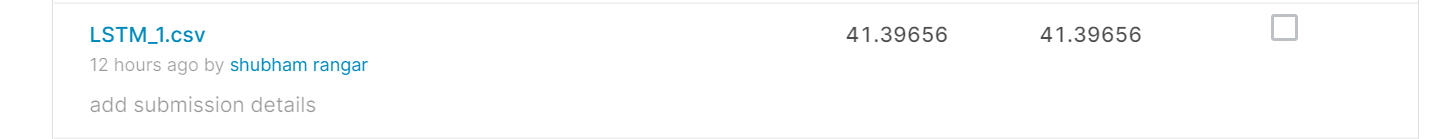

The score is good enough to bring us to top 11 % submission on leaderboard and 118/1095 position.

# All Models Performances

In [147]:
from prettytable import PrettyTable
x = PrettyTable()
x = PrettyTable(["Sno.","Model", "Kaggle Score"])
row1= [1,'Base Line Model',67.593]
row2 = [2,'Decision Tree',60.212]
row3 = [3,'Random Forest',59.240]
row4 = [4,'XgBoost',54.314]
row5 = [5,'LSTM',41.396]
x.add_row(row1)
x.add_row(row2)
x.add_row(row3)
x.add_row(row4)
x.add_row(row5)

print(x)

+------+-----------------+--------------+
| Sno. |      Model      | Kaggle Score |
+------+-----------------+--------------+
|  1   | Base Line Model |    67.593    |
|  2   |  Decision Tree  |    60.212    |
|  3   |  Random Forest  |    59.24     |
|  4   |     XgBoost     |    54.314    |
|  5   |       LSTM      |    41.396    |
+------+-----------------+--------------+
